# <span style="color:teal"> Deep Reinforcement Learning for Atari Enduro-v0 </span>

### Import Required Packages

In [1]:
from time import sleep
from __future__ import division

import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Permute
from keras.layers import Input, Conv2D
from keras.optimizers import Adam
from keras.activations import relu, linear
from keras.layers.advanced_activations import LeakyReLU

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor

Using TensorFlow backend.


***
### RoadRunner Environment

In [2]:
env = gym.make('Enduro-v0')

env.render()
sleep(1)
env.close()

#### 1. *Number of possible action*

In [3]:
nb_actions = env.action_space.n
print('Total number of Possible actoin is :', nb_actions)

Total number of Possible actoin is : 9


#### 2. *Taking stack of 4 consecutive frames*

In [4]:
frame_shape = (84, 84)
window_length = 4
input_shape = (window_length,) + frame_shape
print('Input Shape is :', input_shape)

Input Shape is : (4, 84, 84)


***
### Defining class for pre-processing the game_frames

In [5]:
class GameProcess(Processor):
    def process_observation(self, observation):
        img = Image.fromarray(observation)
        img = np.array(img.resize(frame_shape).convert('L'))
        return img.astype('uint8')  

    def process_state_batch(self, batch):
        Processed_batch = batch.astype('float32') / 255.
        return Processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

***
## DeepMind Architecture

In [6]:
model = Sequential()
model.add(Permute((2, 3, 1), input_shape=input_shape))
model.add(Conv2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Conv2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
activation_2 (Activation)    (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
activation_3 (Activation)    (None, 7, 7, 64)          0         
__________

***
### Configuring the Agent

#### 1. *Allocating memory for experience replay*

In [7]:
memory = SequentialMemory(limit=1000000, window_length=window_length)

#### 2.* Policy: Epsilon Greedy Exploration*
<span style="color:teal">*Gradually exploration will be decreased*</span>

In [8]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=1000000)

#### 3. *Compiling DQN Agent*

In [9]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory, processor=GameProcess(),
               nb_steps_warmup=50000, gamma=.99, target_model_update=10000, train_interval=4, delta_clip=1.)

In [10]:
dqn.compile(Adam(lr=.00025), metrics=['mae'])

***
## <span style="color:teal"> Training the model </span>

#### 1. *Check if Agent is learning for first 0.5M Steps*

In [11]:
history = dqn.fit(env, nb_steps=500000)

Training for 500000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 50s - reward: 0.0000e+00    - ETA: 0s - 
2 episodes - episode_reward: 0.000 [0.000, 0.000] - ale.lives: 0.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 48s - reward: 0.0000e+00    
2 episodes - episode_reward: 0.000 [0.000, 0.000] - ale.lives: 0.000

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 47s - reward: 0.0000e+00    
2 episodes - episode_reward: 0.000 [0.000, 0.000] - ale.lives: 0.000

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 48s - reward: 0.0000e+00    - ETA: 0s - rew - ETA: 0s - rewa
3 episodes - episode_reward: 0.000 [0.000, 0.000] - ale.lives: 0.000

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 50s - reward: 0.0000e+00    
2 episodes - episode_reward: 0.000 [0.000, 0.000] - ale.lives: 0.000

Interval 6 (50000 steps p

10000/10000 [==============================] - 183s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.015 - mean_q: 0.017 - mean_eps: 0.708 - ale.lives: 0.000

Interval 34 (330000 steps performed)
10000/10000 [==============================] - 183s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.014 - mean_q: 0.016 - mean_eps: 0.699 - ale.lives: 0.000

Interval 35 (340000 steps performed)
10000/10000 [==============================] - 184s - reward: 0.0000e+00   - ETA: 0s - reward: 0.0000
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.014 - mean_q: 0.016 - mean_eps: 0.690 - ale.lives: 0.000

Interval 36 (350000 steps performed)
10000/10000 [==============================] - 181s - reward: 0.0000e+00   
3 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.014 - mean_q: 0.016 - mean_ep

#### 2. *Summarizing the training history*

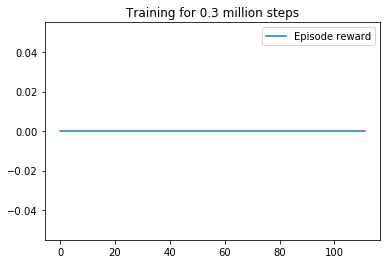

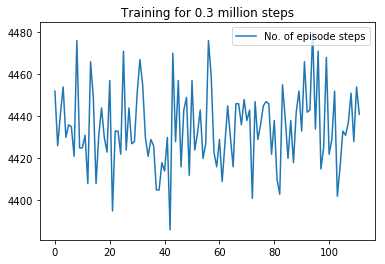

In [19]:
plt.plot(history.history['episode_reward'])
plt.title('Training for 0.3 million steps')
plt.legend(['Episode reward'], loc='upper right')
plt.show()

plt.plot(history.history['nb_episode_steps'])
plt.title('Training for 0.3 million steps')
plt.legend(['No. of episode steps'], loc='upper right')
plt.show()

#### 3. *Saving the weights*

In [13]:
dqn.save_weights('dqn_atari_Enduro.h5f', overwrite=True)

### <span style="color:red">**-  -  Caution   -  -**</span>

### <span style="color:teal">Re-Training the model (for 2M steps)  </span>
*Loading the saved weights (of 0.3M steps)*

In [14]:
dqn.load_weights('dqn_atari_Enduro.h5f')

In [15]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory, processor=GameProcess(),
               gamma=.99, target_model_update=10000, train_interval=4, delta_clip=1.)

dqn.compile(Adam(lr=0.00025), metrics=['mae'])

In [16]:
history2M = dqn.fit(env, nb_steps=2000000)

Training for 2000000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 175s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.012 - mean_q: 0.014 - mean_eps: 0.995 - ale.lives: 0.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 186s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.012 - mean_q: 0.014 - mean_eps: 0.987 - ale.lives: 0.000

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 186s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.012 - mean_q: 0.014 - mean_eps: 0.978 - ale.lives: 0.000

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 185s - reward: 0.0000e+00   
3 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0

10000/10000 [==============================] - 189s - reward: 0.0000e+00   
3 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.009 - mean_q: 0.011 - mean_eps: 0.717 - ale.lives: 0.000

Interval 33 (320000 steps performed)
10000/10000 [==============================] - 189s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.010 - mean_q: 0.011 - mean_eps: 0.708 - ale.lives: 0.000

Interval 34 (330000 steps performed)
10000/10000 [==============================] - 190s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.010 - mean_q: 0.011 - mean_eps: 0.699 - ale.lives: 0.000

Interval 35 (340000 steps performed)
10000/10000 [==============================] - 189s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.009 - mean_q: 0.011 - mean_eps: 0.690 - ale.lives: 0.00

10000/10000 [==============================] - 190s - reward: 0.0000e+00   
3 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.008 - mean_q: 0.009 - mean_eps: 0.438 - ale.lives: 0.000

Interval 64 (630000 steps performed)
10000/10000 [==============================] - 188s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.008 - mean_q: 0.009 - mean_eps: 0.429 - ale.lives: 0.000

Interval 65 (640000 steps performed)
10000/10000 [==============================] - 189s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.008 - mean_q: 0.009 - mean_eps: 0.420 - ale.lives: 0.000

Interval 66 (650000 steps performed)
10000/10000 [==============================] - 188s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.007 - mean_q: 0.009 - mean_eps: 0.411 - ale.lives: 0.00

10000/10000 [==============================] - 191s - reward: 2.0000e-04   
2 episodes - episode_reward: 1.000 [0.000, 2.000] - loss: 0.001 - mean_absolute_error: 0.009 - mean_q: 0.011 - mean_eps: 0.159 - ale.lives: 0.000

Interval 95 (940000 steps performed)
10000/10000 [==============================] - 191s - reward: 0.0000e+00   
3 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.001 - mean_absolute_error: 0.010 - mean_q: 0.011 - mean_eps: 0.150 - ale.lives: 0.000

Interval 96 (950000 steps performed)
10000/10000 [==============================] - 190s - reward: 2.0000e-04   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.001 - mean_absolute_error: 0.012 - mean_q: 0.011 - mean_eps: 0.141 - ale.lives: 0.000

Interval 97 (960000 steps performed)
10000/10000 [==============================] - 188s - reward: -2.0000e-04   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.001 - mean_absolute_error: 0.013 - mean_q: 0.012 - mean_eps: 0.132 - ale.lives: 0.0

10000/10000 [==============================] - 187s - reward: 0.0026   
2 episodes - episode_reward: 17.500 [9.000, 26.000] - loss: 0.005 - mean_absolute_error: 0.188 - mean_q: 0.142 - mean_eps: 0.100 - ale.lives: 0.000

Interval 126 (1250000 steps performed)
10000/10000 [==============================] - 188s - reward: 0.0042   
2 episodes - episode_reward: 15.500 [14.000, 17.000] - loss: 0.006 - mean_absolute_error: 0.201 - mean_q: 0.145 - mean_eps: 0.100 - ale.lives: 0.000

Interval 127 (1260000 steps performed)
10000/10000 [==============================] - 188s - reward: 0.0045   
3 episodes - episode_reward: 14.333 [0.000, 22.000] - loss: 0.006 - mean_absolute_error: 0.207 - mean_q: 0.145 - mean_eps: 0.100 - ale.lives: 0.000

Interval 128 (1270000 steps performed)
10000/10000 [==============================] - 188s - reward: 0.0016   
2 episodes - episode_reward: 14.000 [1.000, 27.000] - loss: 0.007 - mean_absolute_error: 0.228 - mean_q: 0.164 - mean_eps: 0.100 - ale.lives: 0.000

10000/10000 [==============================] - 202s - reward: 0.0166   
2 episodes - episode_reward: 86.000 [71.000, 101.000] - loss: 0.022 - mean_absolute_error: 0.816 - mean_q: 0.664 - mean_eps: 0.100 - ale.lives: 0.000

Interval 157 (1560000 steps performed)
10000/10000 [==============================] - 201s - reward: 0.0169   
2 episodes - episode_reward: 90.000 [82.000, 98.000] - loss: 0.022 - mean_absolute_error: 0.831 - mean_q: 0.682 - mean_eps: 0.100 - ale.lives: 0.000

Interval 158 (1570000 steps performed)
10000/10000 [==============================] - 201s - reward: 0.0236   
3 episodes - episode_reward: 83.667 [37.000, 123.000] - loss: 0.022 - mean_absolute_error: 0.847 - mean_q: 0.700 - mean_eps: 0.100 - ale.lives: 0.000

Interval 159 (1580000 steps performed)
10000/10000 [==============================] - 195s - reward: 0.0174   
2 episodes - episode_reward: 82.000 [78.000, 86.000] - loss: 0.022 - mean_absolute_error: 0.867 - mean_q: 0.734 - mean_eps: 0.100 - ale.lives: 

10000/10000 [==============================] - 195s - reward: 0.0230   - ETA: 0s - rew
2 episodes - episode_reward: 105.500 [63.000, 148.000] - loss: 0.038 - mean_absolute_error: 1.655 - mean_q: 1.625 - mean_eps: 0.100 - ale.lives: 0.000

Interval 188 (1870000 steps performed)
10000/10000 [==============================] - 195s - reward: 0.0320   
2 episodes - episode_reward: 127.000 [94.000, 160.000] - loss: 0.039 - mean_absolute_error: 1.709 - mean_q: 1.701 - mean_eps: 0.100 - ale.lives: 0.000

Interval 189 (1880000 steps performed)
10000/10000 [==============================] - 198s - reward: 0.0170   - ETA: 0
2 episodes - episode_reward: 111.500 [95.000, 128.000] - loss: 0.039 - mean_absolute_error: 1.708 - mean_q: 1.708 - mean_eps: 0.100 - ale.lives: 0.000

Interval 190 (1890000 steps performed)
10000/10000 [==============================] - 197s - reward: 0.0257   
3 episodes - episode_reward: 92.667 [37.000, 126.000] - loss: 0.037 - mean_absolute_error: 1.754 - mean_q: 1.795 - m

*Summarizing the training history*

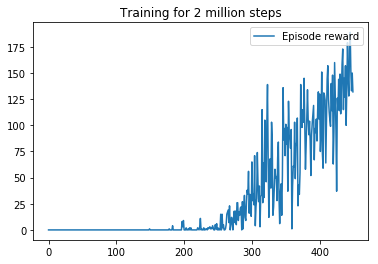

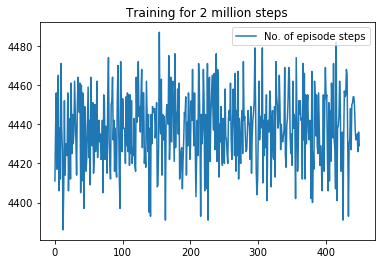

In [18]:
plt.plot(history2M.history['episode_reward'])
plt.title('Training for 2 million steps')
plt.legend(['Episode reward'], loc='upper right')
plt.show()

plt.plot(history2M.history['nb_episode_steps'])
plt.title('Training for 2 million steps')
plt.legend(['No. of episode steps'], loc='upper right')
plt.show()

#### 4. *Saving final weights*

In [20]:
dqn.save_weights('dqn_atari_Enduro.h5f', overwrite=True)

***
## <span style="color:teal"> Testing the model </span>

#### 1. Loading the weights for testing

In [21]:
dqn.load_weights('dqn_atari_Enduro.h5f')

#### 2. Resetting the environment for testing

In [22]:
env.reset()
dqn.test(env, nb_episodes=2, visualize=True)

Testing for 2 episodes ...
Episode 1: reward: 167.000, steps: 4475
Episode 2: reward: 148.000, steps: 4455


In [23]:
env.close()

In [24]:
# Trained on: Intel® Xeon® Processor E5, 2.40 GHz, Nvidia Quadro K4200
# Bhartendu Thakur, Machine Learning & Computing
# https://in.mathworks.com/matlabcentral/profile/authors/10083740-bhartendu?&detail=fileexchange
# https://in.linkedin.com/in/bhartendu-thakur-56bb6285